# **Feature importance**

## Data and Model Import

In [13]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from utils import *


datasets_folder = './datasets'
models_folder = './models'
figsize = (20,4)
verbosity = 0

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[]


In [6]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = list(pollution_data.keys())

In [7]:
station_data = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
        # bin_size = 8,
        # offset = 2
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')
agents = list(set(agent for station in stations for agent in station_data[station].keys()))

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 33


In [8]:
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'

training_sets = {}
test_sets = {}

for station in stations:
    training_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        training_sets[station][agent] = {}
        test_sets[station][agent] = {}

        x_train, y_train, x_test, y_test = create_train_test(station_data[station][agent], train_split_date, y=target)

        training_sets[station][agent]['x'] = x_train
        training_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = x_test
        test_sets[station][agent]['y'] = y_test

In [60]:
models = load_models(models_folder)

Loading model: GIARDINI MARGHERITA.NO2
Loading model: GIARDINI MARGHERITA.O3
Loading model: GIARDINI MARGHERITA.PM10
Loading model: GIARDINI MARGHERITA.PM2_5
Loading model: PORTA SAN FELICE.C6H6
Loading model: PORTA SAN FELICE.CO
Loading model: PORTA SAN FELICE.NO2
Loading model: PORTA SAN FELICE.PM10
Loading model: PORTA SAN FELICE.PM2_5
Loading model: VIA CHIARINI.NO2
Loading model: VIA CHIARINI.O3
Loading model: VIA CHIARINI.PM10


## Explainability with Permutation Importance

In [ ]:
from sklearn.inspection import permutation_importance

agents_permutation_importance = {}

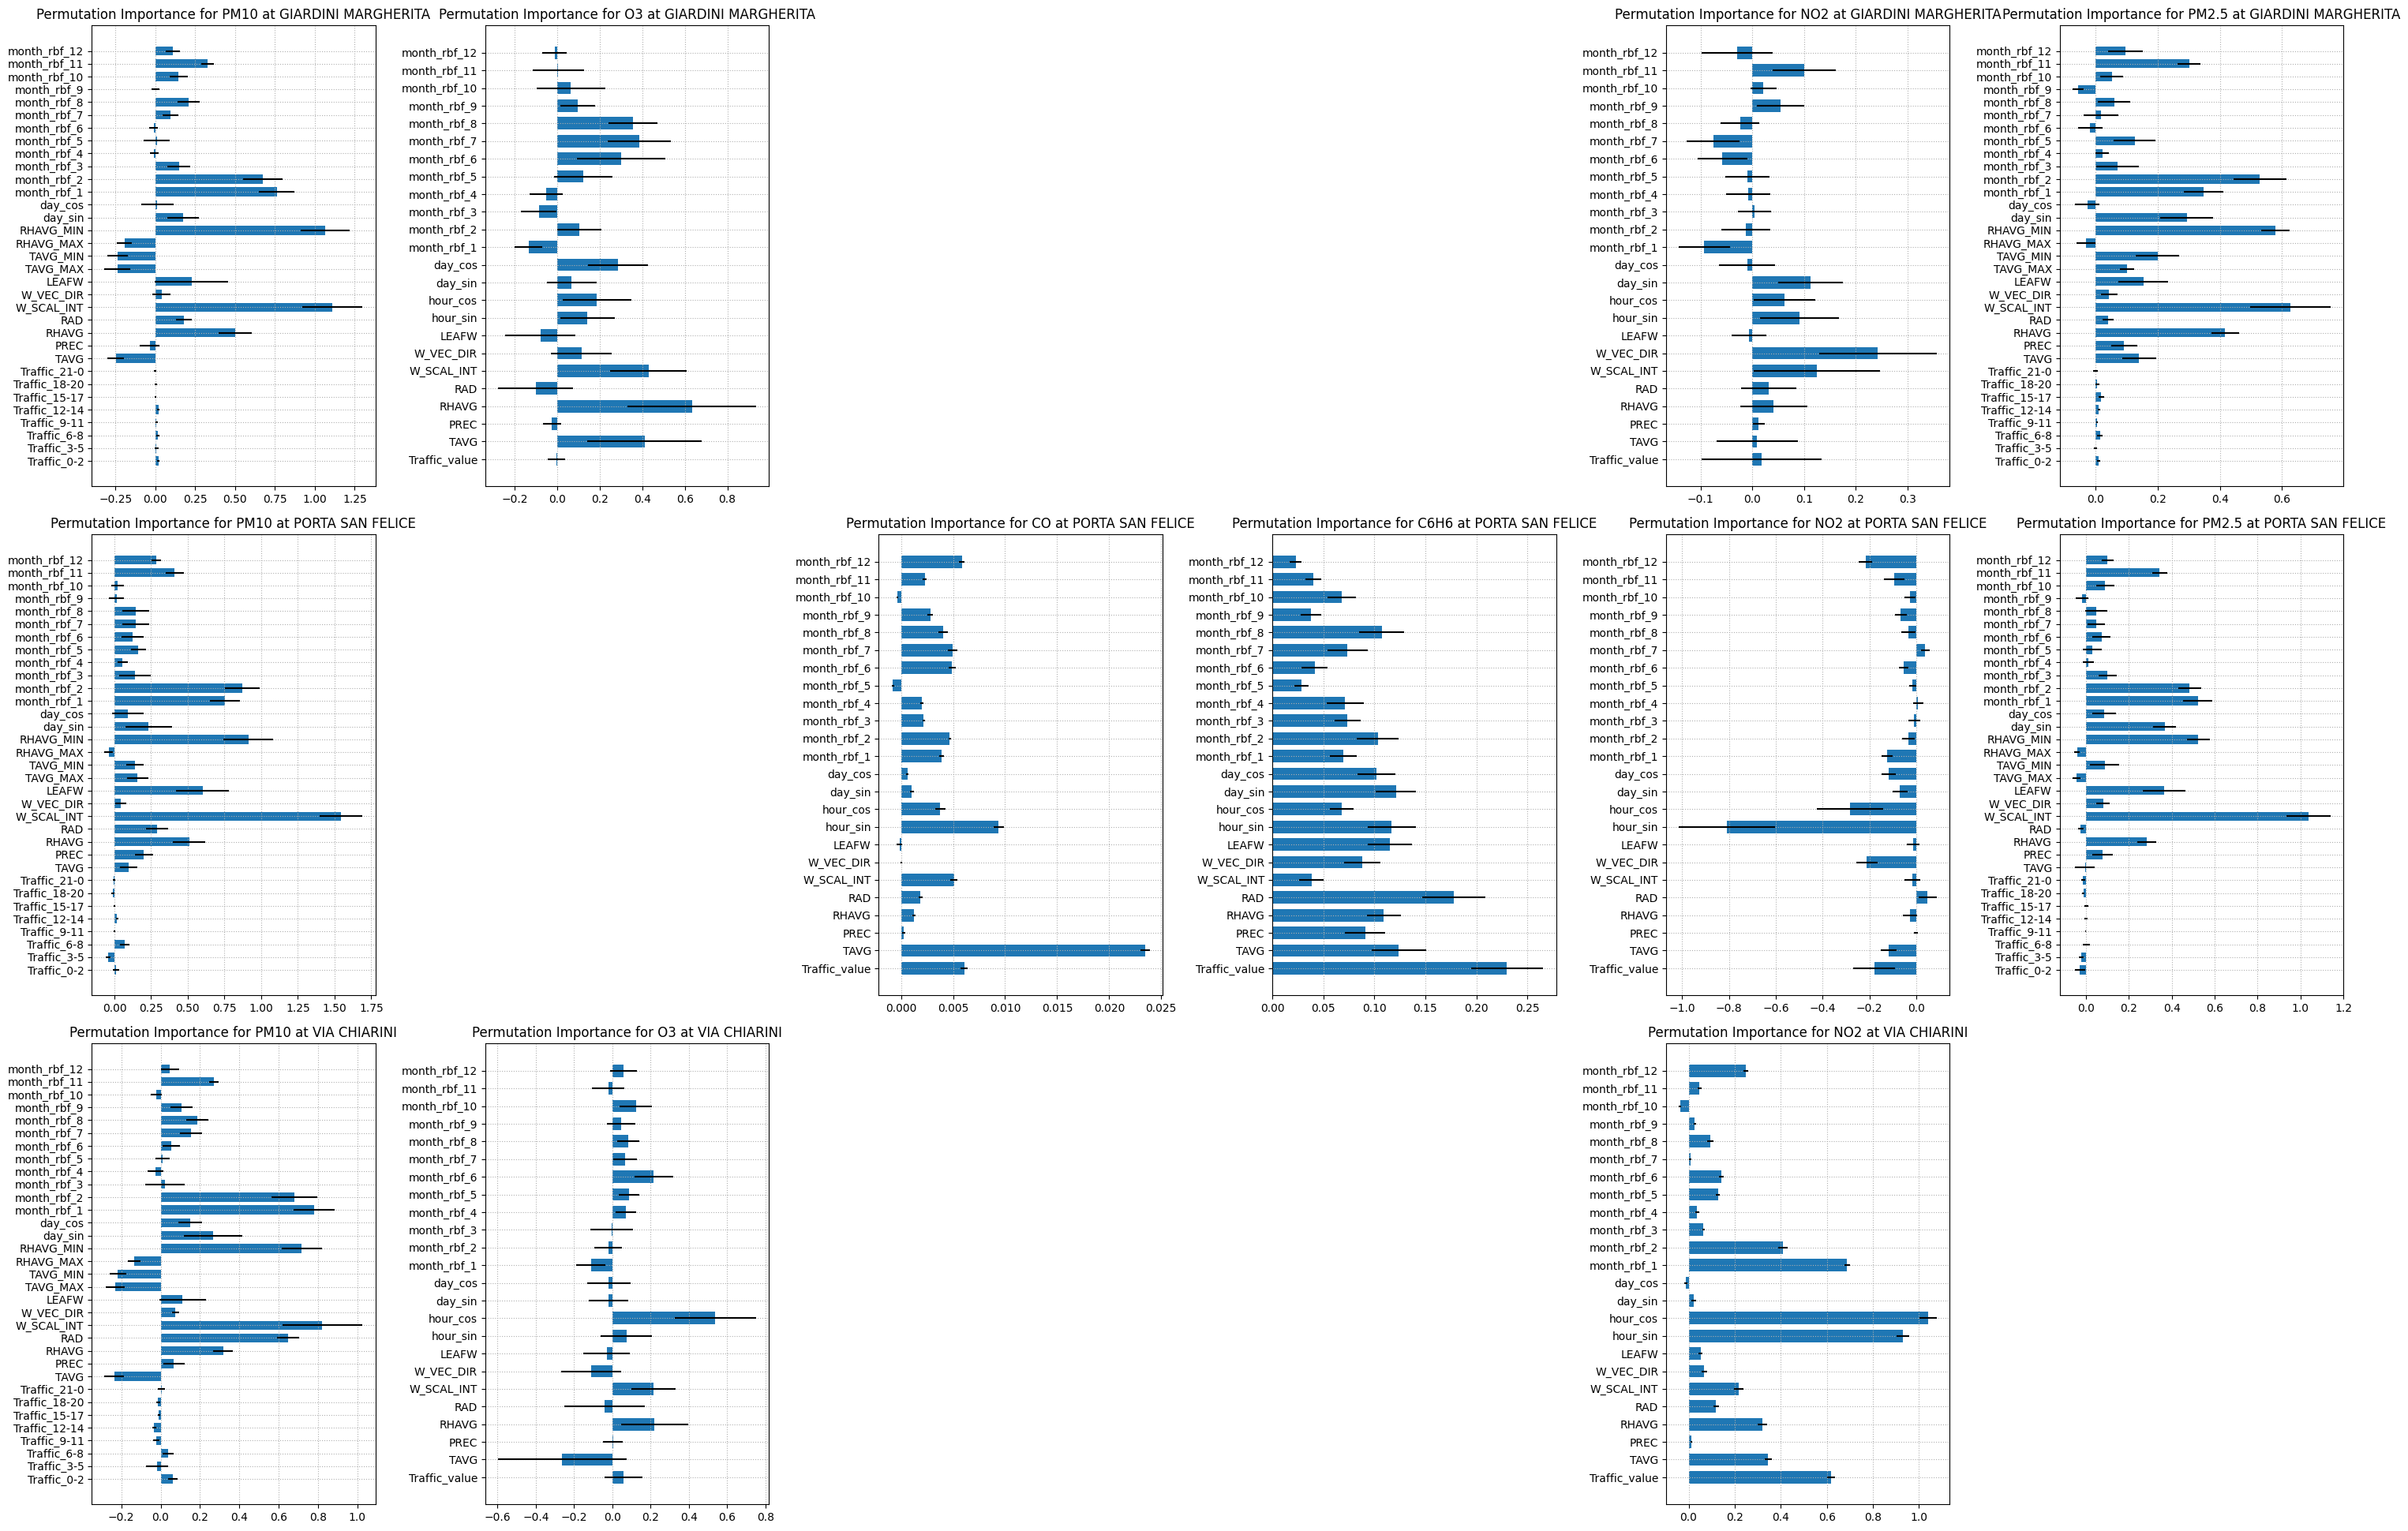

In [71]:
from sklearn.metrics import mean_absolute_error


def neg_mae_scorer(model, X, y):
    try:
        y_pred = model.predict(X, verbose=0)
    except: # sklearn doesnt have verbose
        y_pred = model.predict(X)
    return -mean_absolute_error(y, y_pred)

def lstm_neg_mae_scorer(model, x, y, time_steps, n_features):
    x = x.reshape(-1, time_steps, n_features) # since that this is getting used by permutation_importance, it got 2d data as input and needs to be reshaped
    y_pred = model.predict(x, verbose=0)
    return -mean_absolute_error(y, y_pred)


n_samples = 100 # with this 'low' values I get the same results as higher ones so... lets keep it fast 
n_repeats = 10

n_rows = len(stations)
n_cols = len(agents)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 6.5))

for station in stations:
    if station not in agents_permutation_importance:   
        agents_permutation_importance[station] = {}
    for agent in models[station].keys():
        model = models[station][agent]
        X_test = test_sets[station][agent]['x']
        y_test = test_sets[station][agent]['y']
        features = X_test.columns
        importances = {}
        scoring = neg_mae_scorer
        lstm = False
        input_shape=None

        if isinstance(model, tf.keras.models.Sequential):
            input_shape = model.input_shape
            
            if len(input_shape) == 2: #ffnn or cnn
                # continue
                pass
                
            if len(input_shape) == 3: # lstm
                # continue
                lstm = True
                time_steps = input_shape[1] 
                n_features = input_shape[2] 
                use_mask = isinstance(model.layers[0], tf.keras.layers.Masking)
                X_test, y_test = create_sequences(test_sets[station][agent]['x'], test_sets[station][agent]['y'], time_steps, use_mask=use_mask)
                # X_test, y_test = create_sequences(test_sets[station][agent]['x'].iloc[:3*n_samples], test_sets[station][agent]['y'].iloc[:3*n_samples], time_steps, use_mask=use_mask)
                y_test = y_test.to_numpy()
                test_data_idx = np.random.choice(X_test.shape[0], size=n_samples, replace=False)
                X_test = X_test[test_data_idx]
                y_test = y_test[test_data_idx]
                X_test = X_test.reshape(X_test.shape[0], -1) # permutation_importance does not allow for 3d data

                scoring = lambda model, x, y: lstm_neg_mae_scorer(model, x, y, time_steps, n_features) # lambda bcs we ahd to pass time steps and num. features    
            
        else: # other models
            X_test = X_test.sample(n_samples, random_state=42)
            y_test = y_test.sample(n_samples, random_state=42)

        # print(f'Computing importance for {station} {agent}')

        # compute importances
        importances_result = permutation_importance(model,
                                                    X_test,
                                                    y_test,
                                                    scoring=scoring,
                                                    n_repeats=n_repeats,
                                                    random_state=42)
        
        for key in ('importances_mean', 'importances_std'): # we don't care about the full repetitions values (`importances`)
            val = importances_result[key]
            if lstm: # for the lstm we had to flatten the sequences, now we have one ts*n_feat. total features, so we go back to the original shape averaging
                val = val.reshape(input_shape[1], input_shape[2])
                val = val.mean(axis=0)
            importances[key] = val

        # save the importances
        agents_permutation_importance[station][agent] = importances

        # plot
        ax = axes[stations.index(station)][agents.index(agent)]
        ax.barh(features, importances['importances_mean'], height=0.7, xerr=importances['importances_std'])
        # ax.bar(X_test.columns, importances.importances_mean, width=0.7, yerr=importances.importances_std)
        # ax.set_xticklabels(X_test.columns, rotation=90)
        ax.set_title(f'Permutation Importance for {agent} at {station}')
        ax.grid(linestyle=':')

for station in stations:
    for agent in agents:
        if agent not in models[station]:
            axes[stations.index(station)][agents.index(agent)].axis('off') # remove unused subplots

plt.tight_layout()
# plt.subplots_adjust(hspace=0.5)
plt.show()

## Explainability with SHAP

In [10]:
import shap

agents_shap_values = {}

d:\GitHub\AII-project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


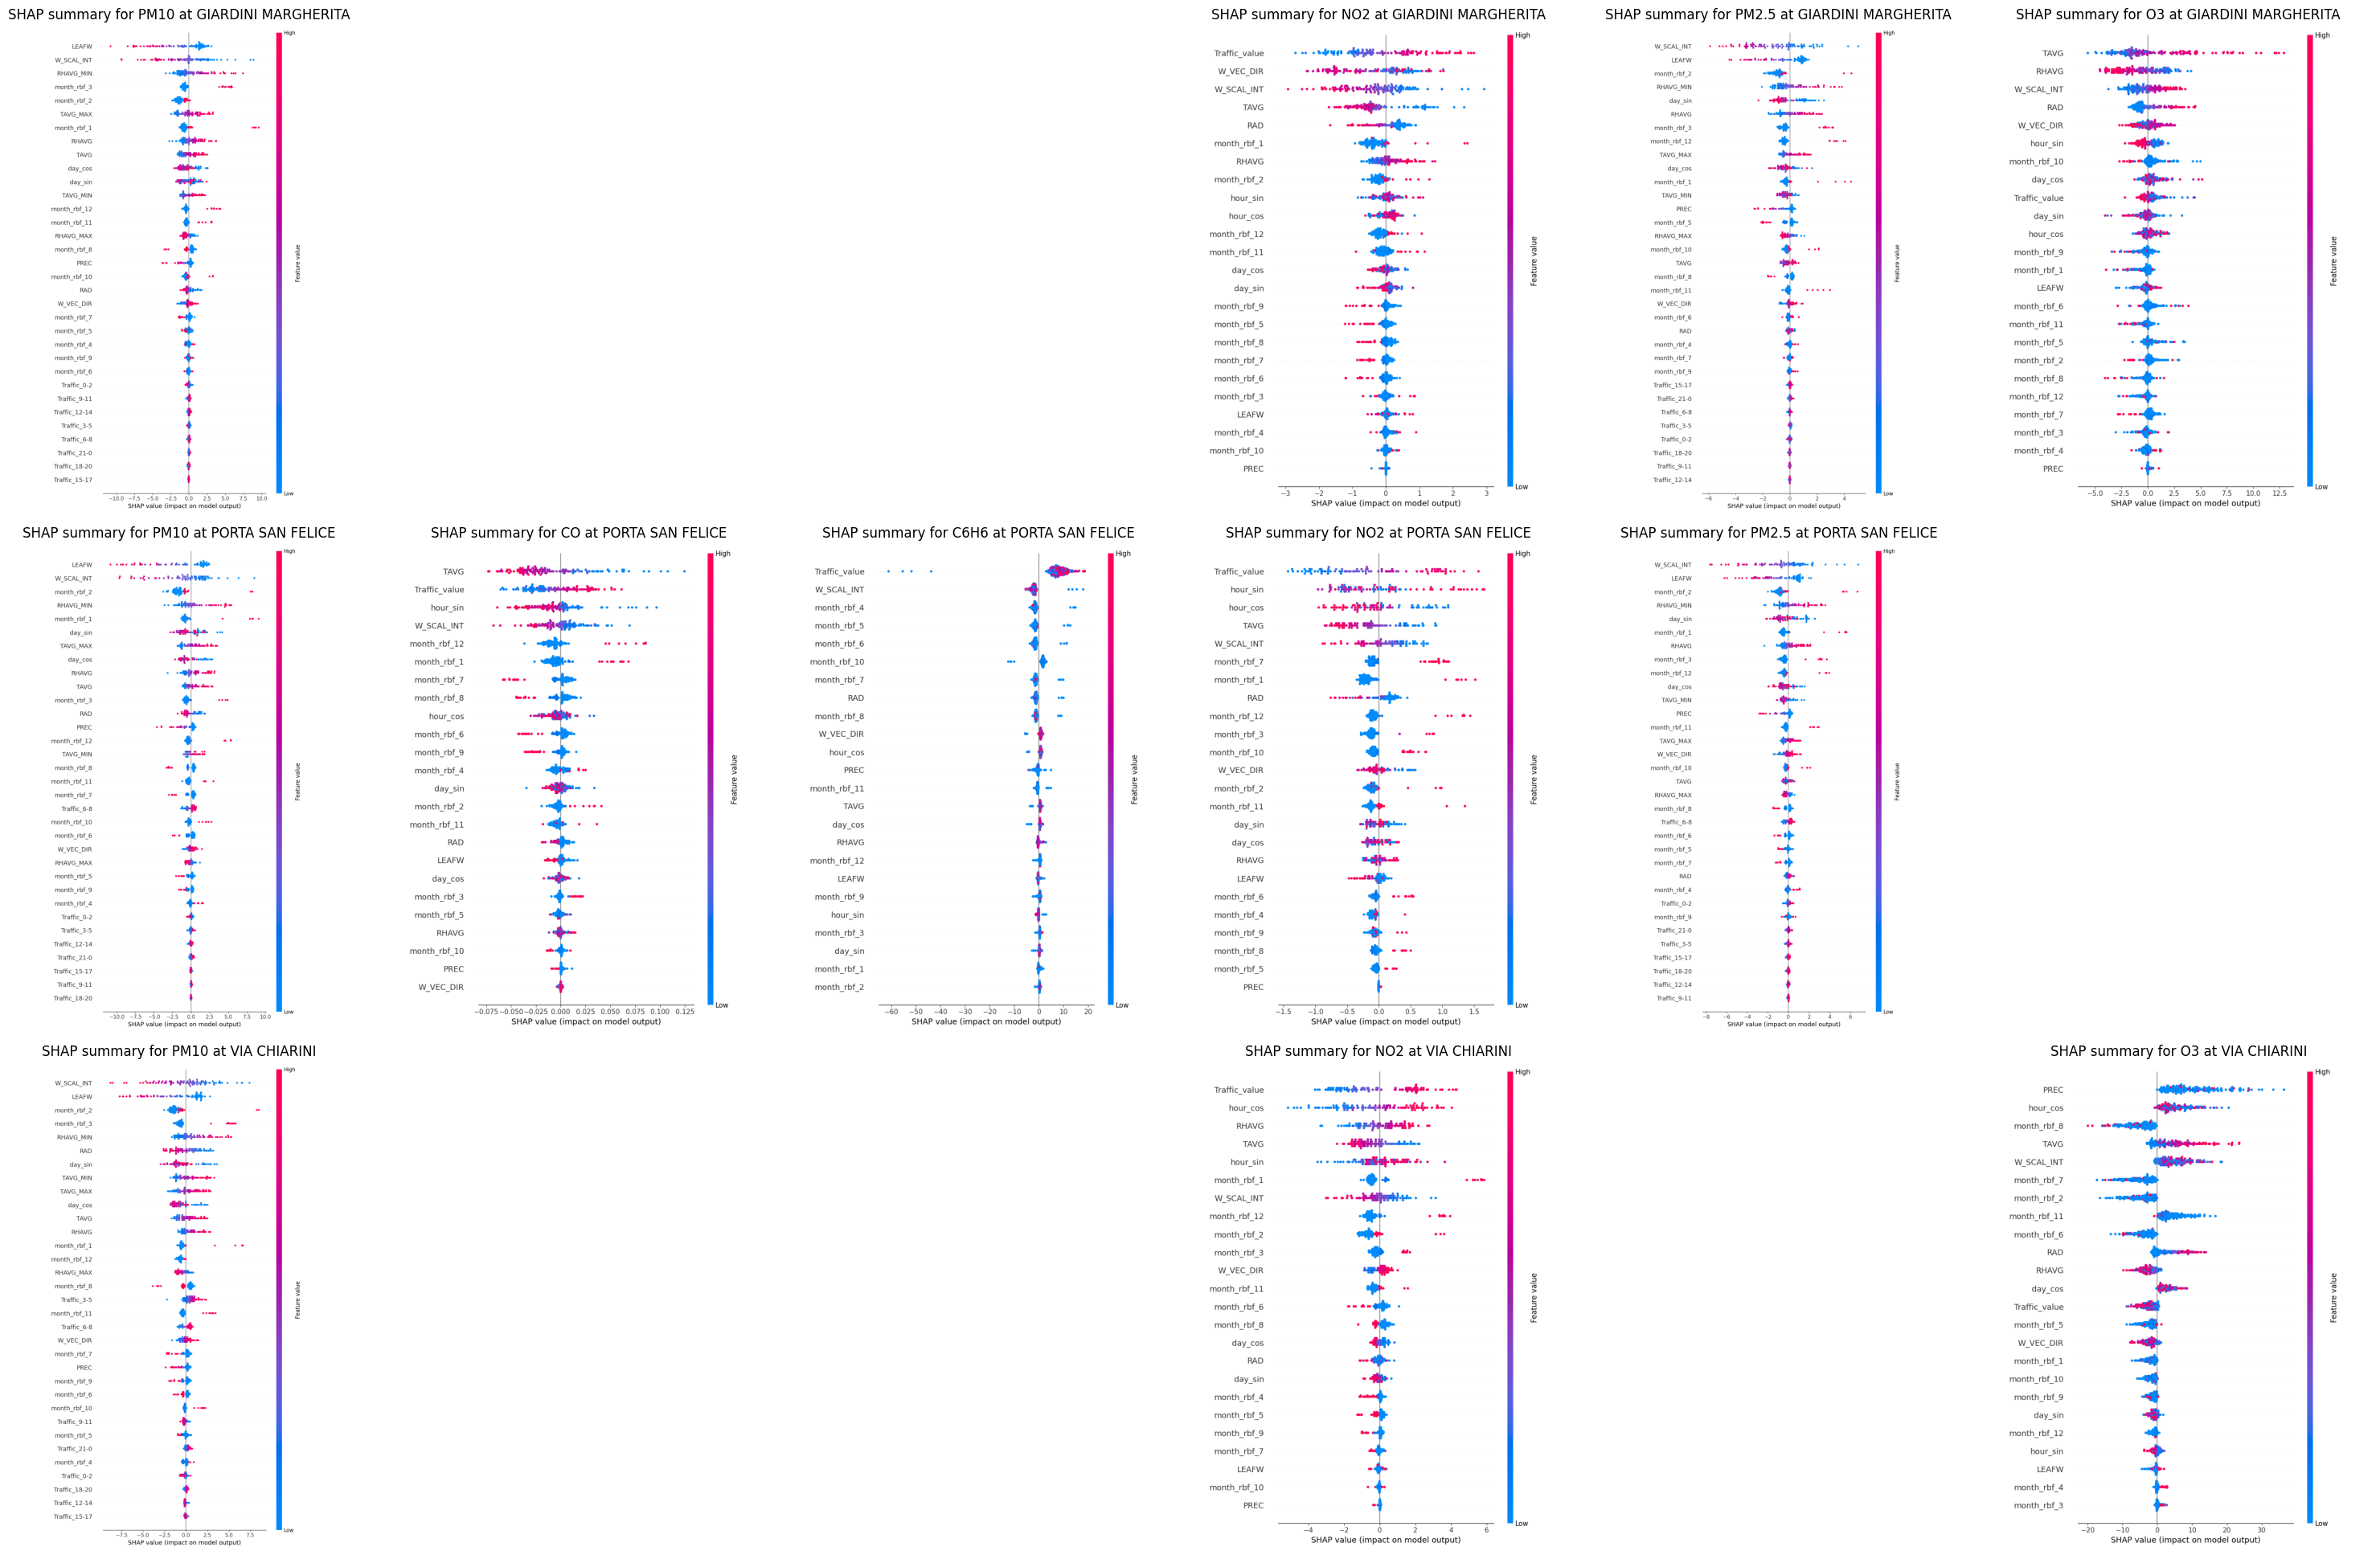

In [11]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import warnings

# shap raises this warning
warnings.filterwarnings(
    "ignore",
    message="`tf.keras.backend.set_learning_phase` is deprecated",
    category=UserWarning,
    module="keras.backend"
)


def model_predict(data): # used in kernel explainers
    return model.predict(data,verbose=0).reshape(-1) # with no reshaping it does not work

n_samples = 200

n_rows = len(stations)
n_cols = len(agents)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 6.5))

for station in stations:
    if station not in agents_shap_values:   
        agents_shap_values[station] = {}
    for agent in models[station].keys():
        model = models[station][agent]
        if isinstance(model, tf.keras.models.Sequential):
            training_data = None
            test_data = None
            shap_values = None
            input_shape = model.input_shape

            if len(input_shape) == 2: # ffnn or cnn
                # continue
                training_data = training_sets[station][agent]['x'].sample(n_samples, random_state=42)
                test_data = test_sets[station][agent]['x'].sample(n_samples, random_state=42)
                
                # deep (doesnt work)
                # explainer = shap.DeepExplainer(model, training_data)
                
                # kernel (has to predict and becomes so slow with many samples)
                # explainer = shap.KernelExplainer(model_predict, training_data)
                # shap_values = explainer.shap_values(test_data)

                # gradient
                explainer = shap.GradientExplainer(model, training_data)
                shap_values = explainer.shap_values(np.array(test_data))
                shap_values = shap_values.squeeze()

            if len(input_shape) == 3: # lstm
                # continue
                time_steps = input_shape[1] 
                use_mask = isinstance(model.layers[0], tf.keras.layers.Masking)
                training_data, _ = create_sequences(training_sets[station][agent]['x'], training_sets[station][agent]['y'], time_steps, use_mask=use_mask)
                test_data, _ = create_sequences(test_sets[station][agent]['x'], test_sets[station][agent]['y'], time_steps, use_mask=use_mask)
                # training_data, _ = create_sequences(training_sets[station][agent]['x'].iloc[:3*n_samples], training_sets[station][agent]['y'].iloc[:3*n_samples], time_steps, use_mask=use_mask)
                # test_data, _ = create_sequences(test_sets[station][agent]['x'].iloc[:3*n_samples], test_sets[station][agent]['y'].iloc[:3*n_samples], time_steps, use_mask=use_mask)
                
                # if you sample before creating the sequences you would separate consecutive values. We might want to sample groups of time_steps elements
                # and then create sequences with no sliding window. Or simply shrinken the dataset before, you need num_samples + time_steps -1 hours in total,
                # so maybe keep 2/3 times num_samples before creating sequences <-- currenty doing this (missing the first `times_steps` -1 elements)
                training_data_idx = np.random.choice(training_data.shape[0], size=n_samples, replace=False)
                test_data_idx = np.random.choice(test_data.shape[0], size=n_samples, replace=False)
                training_data = training_data[training_data_idx]
                test_data = test_data[test_data_idx]

                # deep (doesnt work)
                # explainer = shap.DeepExplainer(model, training_data)
                
                # gradient
                explainer = shap.GradientExplainer(model, training_data)
                shap_values = explainer.shap_values(test_data)
                shap_values = np.mean(np.squeeze(shap_values), axis=1)
                test_data = pd.DataFrame(test_data.mean(axis=1), columns=test_sets[station][agent]['x'].columns)

                # kernel (might work if passed time averaged data, idk tho)
                # explainer = shap.KernelExplainer(model_predict, training_data)
                # shap_values = explainer.shap_values(test_data.reshape(test_data.shape[0], -1))
                # shap_values = explainer.shap_values(test_data)

        elif isinstance(model, RandomForestRegressor):
            # continue
            explainer = shap.TreeExplainer(model)
            test_data = test_sets[station][agent]['x'].sample(n_samples, random_state=42)
            shap_values = explainer.shap_values(test_data)

        z_scores = np.abs((shap_values - shap_values.mean(axis=0)) / shap_values.std(axis=0))
        shap_values = shap_values[(z_scores < 3).all(axis=1)]
        test_data = test_data[(z_scores < 3).all(axis=1)]
        
        # save the shap values
        agents_shap_values[station][agent] = {
            'shap_values': shap_values,
            'explainer':  explainer
        }

        # plot
        ax = axes[stations.index(station)][agents.index(agent)]
        tmp_fig, tmp_ax = plt.subplots(figsize=(5, 4))
        shap.summary_plot(shap_values,
                          test_data,
                          max_display=999,
                          show=False,
                          color_bar=True,
                          rng=42
                          )
        canvas = FigureCanvas(tmp_fig)
        canvas.draw()

        # Convert canvas to image
        image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(tmp_fig.canvas.get_width_height()[::-1] + (4,))

        # Show the image on the target subplot
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f'SHAP summary for {agent} at {station}')

        plt.close(tmp_fig)

for station in stations:
    for agent in agents:
        if agent not in models[station]:
            axes[stations.index(station)][agents.index(agent)].axis('off') # remove unused subplots
plt.tight_layout()
plt.show()

In [ ]:
a=3
station = 'PORTA SAN FELICE'
agent = 'C6H6'

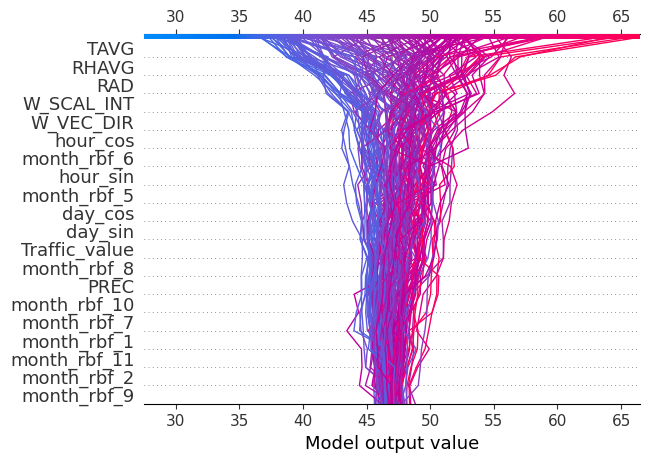

In [ ]:
shaps = agents_shap_values[station][agent]
# plt.figure(figsize=(50,15))
shap.plots.decision(
    np.mean(test_sets[station][agent]['y']),
    shaps['shap_values'],
    feature_names=test_sets[station][agent]['x'].columns.to_numpy(),
    auto_size_plot=False,
)

### SHAP Values

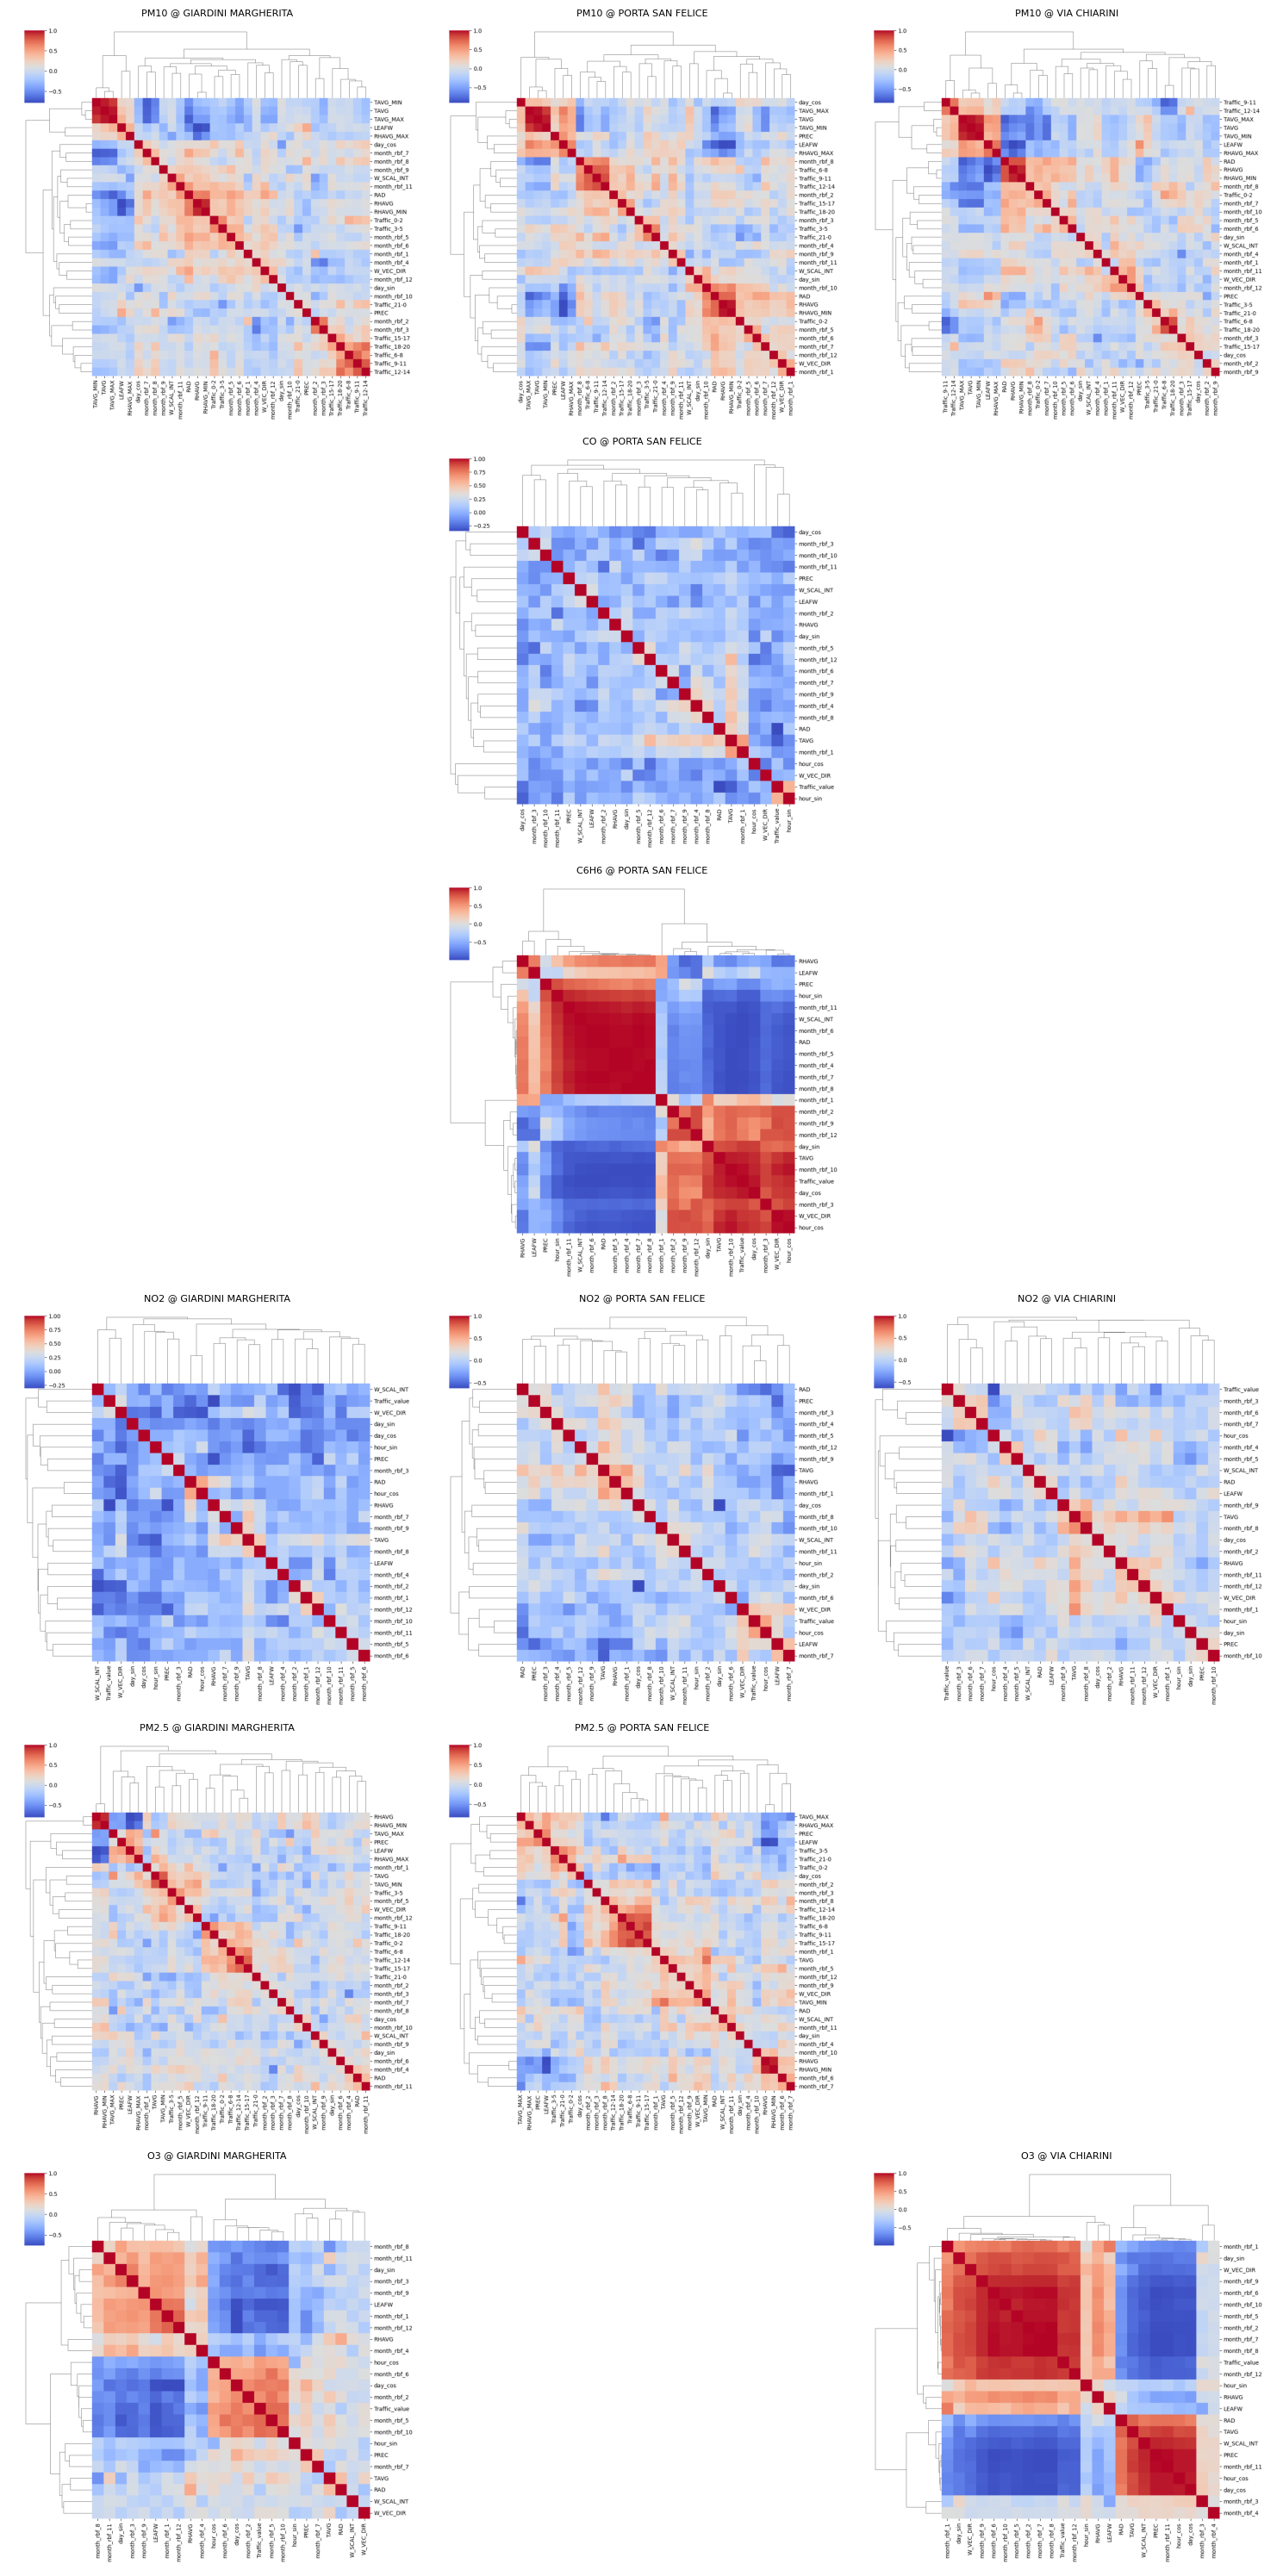

In [ ]:
n_rows = len(agents)
n_cols = len(stations)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

for station in stations:
    for agent in agents_shap_values[station]:
        ax = axes[agents.index(agent)][stations.index(station)]
        shap_df = pd.DataFrame(agents_shap_values[station][agent]['shap_values'], columns=test_sets[station][agent]['x'].columns)
        tmp_fig = sns.clustermap(
            shap_df.corr(),
            cmap="coolwarm",
            # figsize=(5, 4)
        ).fig

        # Draw to canvas and convert to image
        canvas = FigureCanvas(tmp_fig)
        canvas.draw()
        image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(tmp_fig.canvas.get_width_height()[::-1] + (4,))

        # Display image in subplot
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"{agent} @ {station}", fontsize=8)

        plt.close(tmp_fig)
for station in stations:
    for agent in agents:
        if agent not in models[station]:
            axes[agents.index(agent)][stations.index(station)].axis('off') # remove unused subplots
plt.tight_layout()
plt.show()

### Training Data

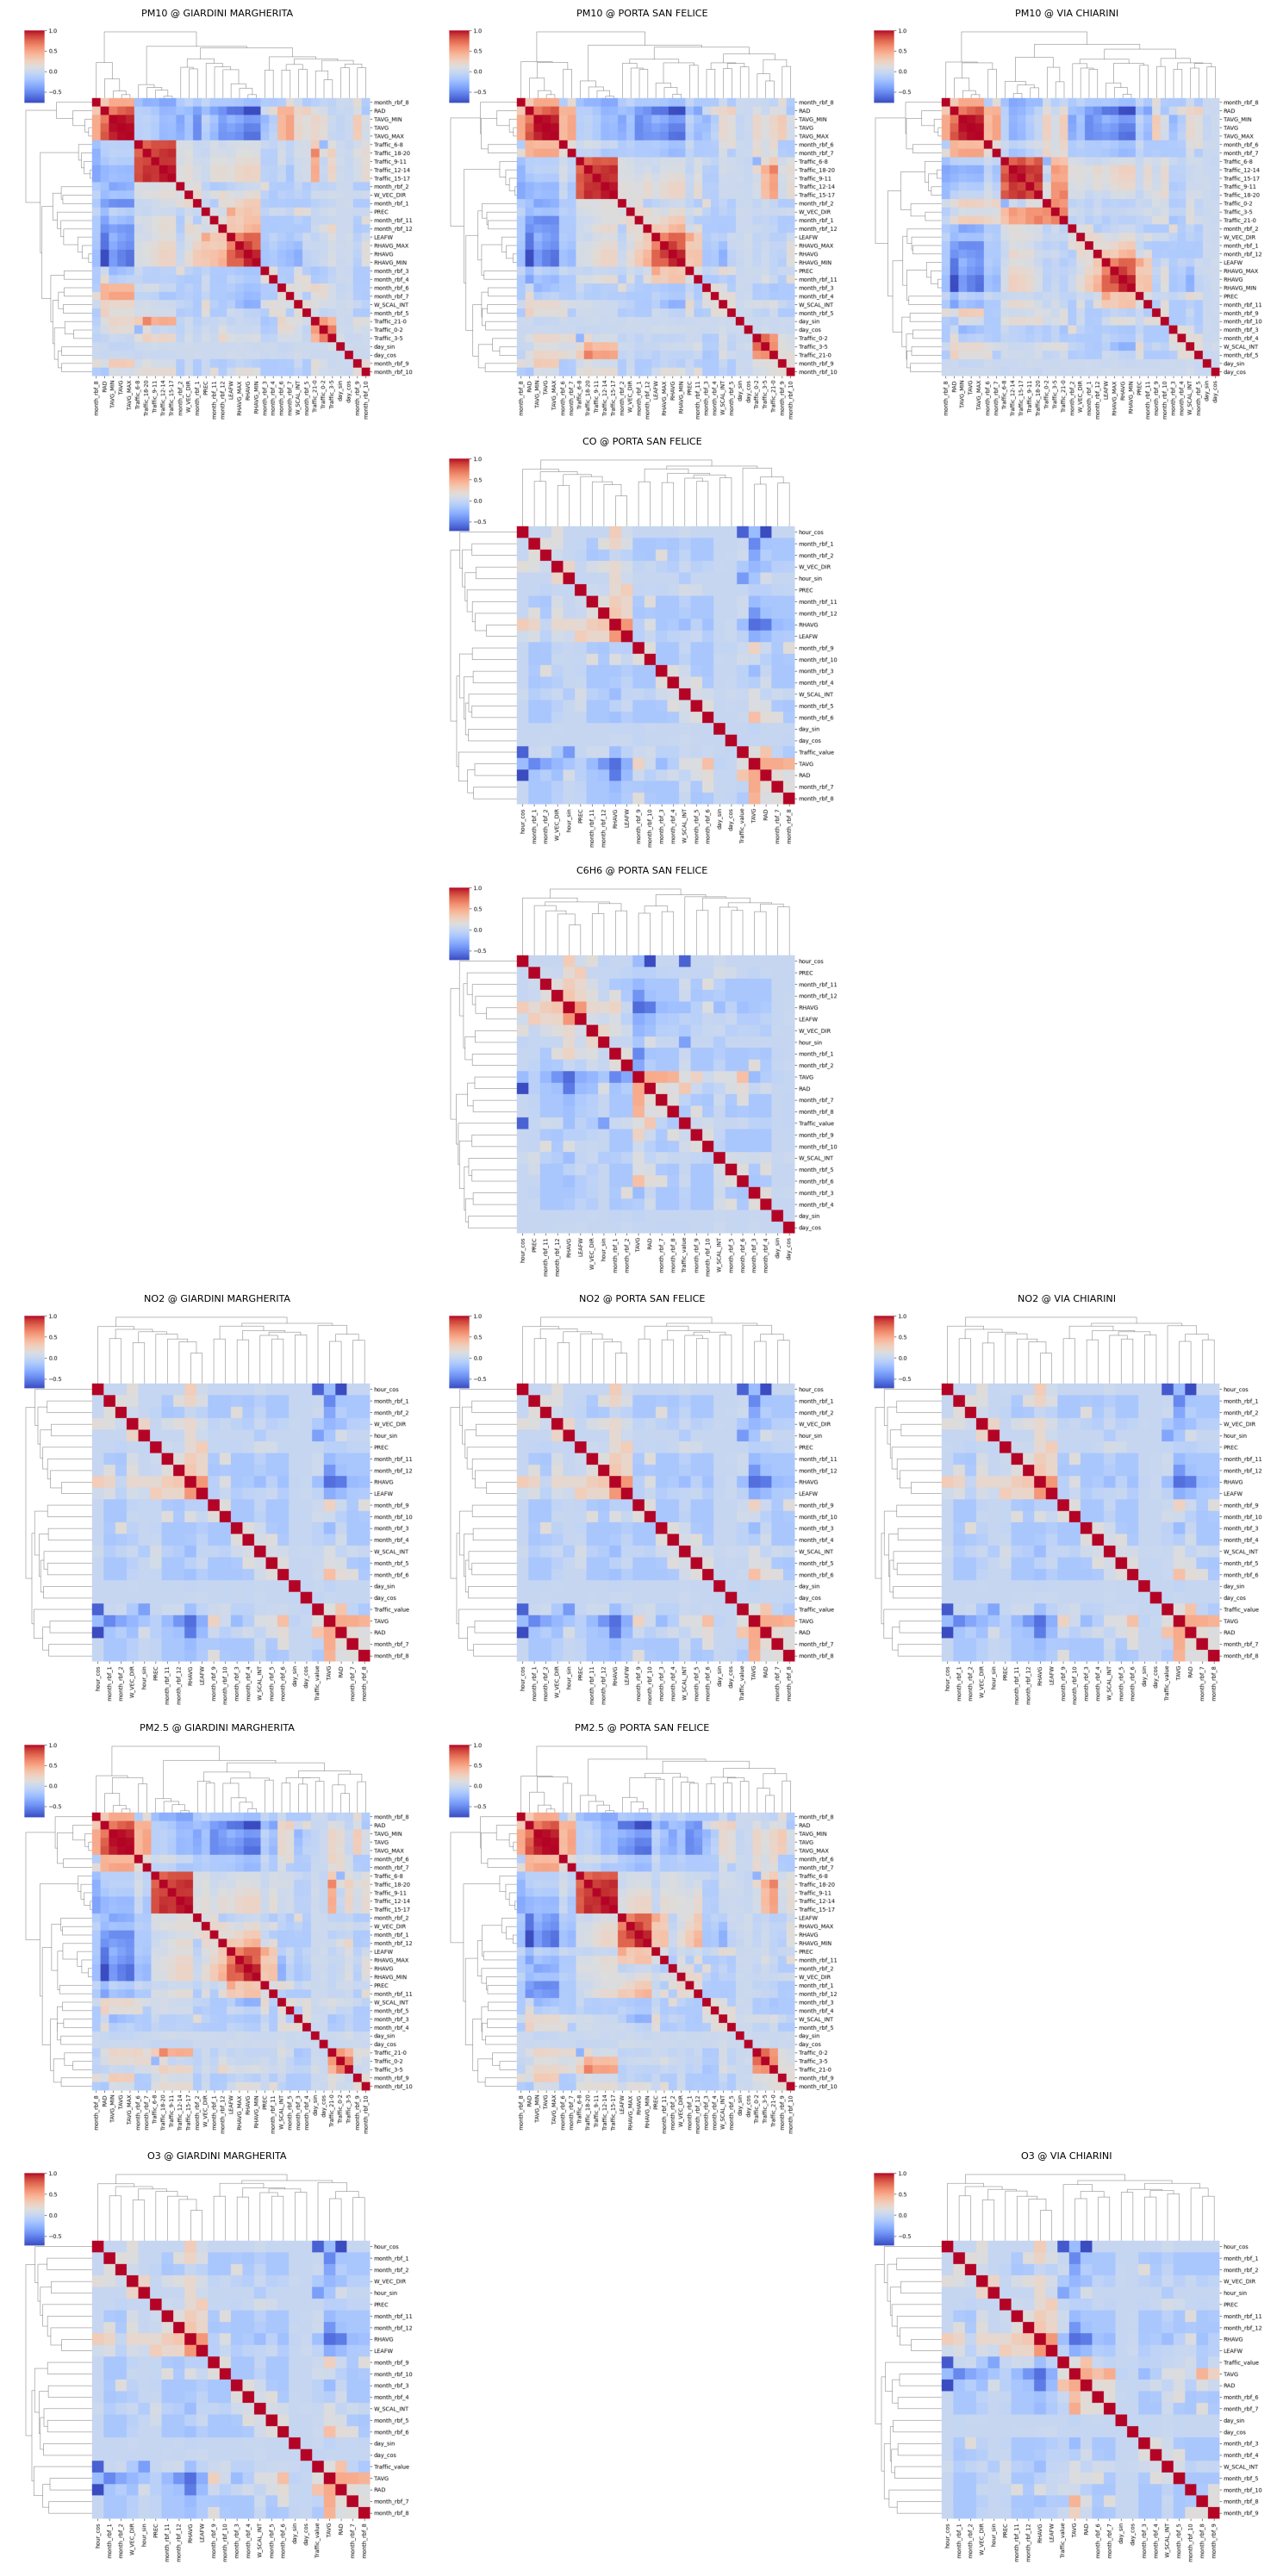

In [74]:
n_rows = len(agents)
n_cols = len(stations)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

for station in stations:
    for agent in agents_shap_values[station]:
        ax = axes[agents.index(agent)][stations.index(station)]
        tmp_fig = sns.clustermap(
            training_sets[station][agent]['x'].corr(),
            cmap="coolwarm",
            # figsize=(5, 4)
        ).fig

        # Draw to canvas and convert to image
        canvas = FigureCanvas(tmp_fig)
        canvas.draw()
        image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(tmp_fig.canvas.get_width_height()[::-1] + (4,))

        # Display image in subplot
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"{agent} @ {station}", fontsize=8)

        plt.close(tmp_fig)
for station in stations:
    for agent in agents:
        if agent not in models[station]:
            axes[agents.index(agent)][stations.index(station)].axis('off') # remove unused subplots
plt.tight_layout()
plt.show()

## Results

We list all the features that doesnt seem to help the model or that are not really coherent.

In [23]:
shap_feature_importance = extract_ordered_features_by_shap(agents_shap_values, test_sets)
print('shap_feature_importance = {')
for station in shap_feature_importance:
    print(f"'{station}': {{")
    for agent in shap_feature_importance[station]:
        print(f"       '{agent}': [", end='')
        print(', '.join([f"'{e}'" for e in shap_feature_importance[station][agent]]),'],')
    print('    },')
print('}')

shap_feature_importance = {
'GIARDINI MARGHERITA': {
       'NO2': ['Traffic_value', 'W_VEC_DIR', 'W_SCAL_INT', 'TAVG', 'RAD', 'month_rbf_1', 'RHAVG', 'month_rbf_2', 'hour_sin', 'hour_cos', 'month_rbf_12', 'month_rbf_11', 'day_cos', 'day_sin', 'month_rbf_9', 'month_rbf_5', 'month_rbf_8', 'month_rbf_7', 'month_rbf_6', 'month_rbf_3', 'LEAFW', 'month_rbf_4', 'month_rbf_10', 'PREC' ],
       'O3': ['TAVG', 'RHAVG', 'W_SCAL_INT', 'RAD', 'W_VEC_DIR', 'hour_sin', 'month_rbf_10', 'day_cos', 'Traffic_value', 'day_sin', 'hour_cos', 'month_rbf_9', 'month_rbf_1', 'LEAFW', 'month_rbf_6', 'month_rbf_11', 'month_rbf_5', 'month_rbf_2', 'month_rbf_8', 'month_rbf_12', 'month_rbf_7', 'month_rbf_3', 'month_rbf_4', 'PREC' ],
       'PM10': ['LEAFW', 'W_SCAL_INT', 'RHAVG_MIN', 'month_rbf_3', 'month_rbf_2', 'TAVG_MAX', 'month_rbf_1', 'RHAVG', 'TAVG', 'day_cos', 'day_sin', 'TAVG_MIN', 'month_rbf_12', 'month_rbf_11', 'RHAVG_MAX', 'month_rbf_8', 'PREC', 'month_rbf_10', 'RAD', 'W_VEC_DIR', 'month_rbf_7', 'month_

##### old results:

In [ ]:
shap_feature_importance = {
'GIARDINI MARGHERITA': {
       'NO2': ['Traffic_value', 'W_VEC_DIR', 'W_SCAL_INT', 'TAVG', 'RAD', 'month_rbf_1', 'RHAVG', 'month_rbf_2', 'hour_sin', 'hour_cos', 'month_rbf_12', 'month_rbf_11', 'day_cos', 'day_sin', 'month_rbf_9', 'month_rbf_5', 'month_rbf_8', 'month_rbf_7', 'month_rbf_6', 'month_rbf_3', 'LEAFW', 'month_rbf_4', 'month_rbf_10', 'PREC' ],
       'O3': ['TAVG', 'RHAVG', 'W_SCAL_INT', 'RAD', 'W_VEC_DIR', 'hour_sin', 'month_rbf_10', 'day_cos', 'Traffic_value', 'day_sin', 'hour_cos', 'month_rbf_9', 'month_rbf_1', 'LEAFW', 'month_rbf_6', 'month_rbf_11', 'month_rbf_5', 'month_rbf_2', 'month_rbf_8', 'month_rbf_12', 'month_rbf_7', 'month_rbf_3', 'month_rbf_4', 'PREC' ],
       'PM10': ['LEAFW', 'W_SCAL_INT', 'RHAVG_MIN', 'month_rbf_3', 'month_rbf_2', 'TAVG_MAX', 'month_rbf_1', 'RHAVG', 'TAVG', 'day_cos', 'day_sin', 'TAVG_MIN', 'month_rbf_12', 'month_rbf_11', 'RHAVG_MAX', 'month_rbf_8', 'PREC', 'month_rbf_10', 'RAD', 'W_VEC_DIR', 'month_rbf_7', 'month_rbf_5', 'month_rbf_4', 'month_rbf_9', 'month_rbf_6', 'Traffic_0-2', 'Traffic_9-11', 'Traffic_12-14', 'Traffic_3-5', 'Traffic_6-8', 'Traffic_21-0', 'Traffic_18-20', 'Traffic_15-17' ],
       'PM2.5': ['W_SCAL_INT', 'LEAFW', 'month_rbf_2', 'RHAVG_MIN', 'day_sin', 'RHAVG', 'month_rbf_3', 'month_rbf_12', 'TAVG_MAX', 'day_cos', 'month_rbf_1', 'TAVG_MIN', 'PREC', 'month_rbf_5', 'RHAVG_MAX', 'month_rbf_10', 'TAVG', 'month_rbf_8', 'month_rbf_11', 'W_VEC_DIR', 'month_rbf_6', 'RAD', 'month_rbf_4', 'month_rbf_7', 'month_rbf_9', 'Traffic_15-17', 'Traffic_21-0', 'Traffic_6-8', 'Traffic_3-5', 'Traffic_0-2', 'Traffic_18-20', 'Traffic_9-11', 'Traffic_12-14' ],
    },
'PORTA SAN FELICE': {
       'C6H6': ['Traffic_value', 'W_SCAL_INT', 'month_rbf_4', 'month_rbf_5', 'month_rbf_6', 'month_rbf_10', 'month_rbf_7', 'RAD', 'month_rbf_8', 'W_VEC_DIR', 'hour_cos', 'PREC', 'month_rbf_11', 'TAVG', 'day_cos', 'RHAVG', 'month_rbf_12', 'LEAFW', 'month_rbf_9', 'hour_sin', 'month_rbf_3', 'day_sin', 'month_rbf_1', 'month_rbf_2' ],
       'CO': ['TAVG', 'Traffic_value', 'hour_sin', 'W_SCAL_INT', 'month_rbf_12', 'month_rbf_1', 'month_rbf_7', 'month_rbf_8', 'hour_cos', 'month_rbf_6', 'month_rbf_9', 'month_rbf_4', 'day_sin', 'month_rbf_2', 'month_rbf_11', 'RAD', 'LEAFW', 'day_cos', 'month_rbf_3', 'month_rbf_5', 'RHAVG', 'month_rbf_10', 'PREC', 'W_VEC_DIR' ],
       'NO2': ['Traffic_value', 'hour_sin', 'hour_cos', 'TAVG', 'W_SCAL_INT', 'month_rbf_7', 'month_rbf_1', 'RAD', 'month_rbf_12', 'month_rbf_3', 'month_rbf_10', 'W_VEC_DIR', 'month_rbf_2', 'month_rbf_11', 'day_sin', 'day_cos', 'RHAVG', 'LEAFW', 'month_rbf_6', 'month_rbf_4', 'month_rbf_9', 'month_rbf_8', 'month_rbf_5', 'PREC' ],
       'PM10': ['LEAFW', 'W_SCAL_INT', 'month_rbf_2', 'RHAVG_MIN', 'month_rbf_1', 'day_sin', 'TAVG_MAX', 'day_cos', 'RHAVG', 'TAVG', 'month_rbf_3', 'RAD', 'PREC', 'month_rbf_12', 'TAVG_MIN', 'month_rbf_8', 'month_rbf_11', 'month_rbf_7', 'Traffic_6-8', 'month_rbf_10', 'month_rbf_6', 'W_VEC_DIR', 'RHAVG_MAX', 'month_rbf_5', 'month_rbf_9', 'month_rbf_4', 'Traffic_0-2', 'Traffic_3-5', 'Traffic_12-14', 'Traffic_21-0', 'Traffic_15-17', 'Traffic_9-11', 'Traffic_18-20' ],
       'PM2.5': ['W_SCAL_INT', 'LEAFW', 'month_rbf_2', 'RHAVG_MIN', 'day_sin', 'month_rbf_1', 'RHAVG', 'month_rbf_3', 'month_rbf_12', 'day_cos', 'TAVG_MIN', 'PREC', 'month_rbf_11', 'TAVG_MAX', 'W_VEC_DIR', 'month_rbf_10', 'TAVG', 'RHAVG_MAX', 'month_rbf_8', 'Traffic_6-8', 'month_rbf_6', 'month_rbf_5', 'month_rbf_7', 'RAD', 'month_rbf_4', 'Traffic_0-2', 'month_rbf_9', 'Traffic_21-0', 'Traffic_3-5', 'Traffic_15-17', 'Traffic_18-20', 'Traffic_12-14', 'Traffic_9-11' ],
    },
'VIA CHIARINI': {
       'NO2': ['Traffic_value', 'hour_cos', 'RHAVG', 'TAVG', 'hour_sin', 'month_rbf_1', 'W_SCAL_INT', 'month_rbf_12', 'month_rbf_2', 'month_rbf_3', 'W_VEC_DIR', 'month_rbf_11', 'month_rbf_6', 'month_rbf_8', 'day_cos', 'RAD', 'day_sin', 'month_rbf_4', 'month_rbf_5', 'month_rbf_9', 'month_rbf_7', 'LEAFW', 'month_rbf_10', 'PREC' ],
       'O3': ['PREC', 'hour_cos', 'month_rbf_8', 'TAVG', 'W_SCAL_INT', 'month_rbf_7', 'month_rbf_2', 'month_rbf_11', 'month_rbf_6', 'RAD', 'RHAVG', 'day_cos', 'Traffic_value', 'month_rbf_5', 'W_VEC_DIR', 'month_rbf_1', 'month_rbf_10', 'month_rbf_9', 'day_sin', 'month_rbf_12', 'hour_sin', 'LEAFW', 'month_rbf_4', 'month_rbf_3' ],
       'PM10': ['W_SCAL_INT', 'LEAFW', 'month_rbf_2', 'month_rbf_3', 'RHAVG_MIN', 'RAD', 'day_sin', 'TAVG_MIN', 'TAVG_MAX', 'day_cos', 'TAVG', 'RHAVG', 'month_rbf_1', 'month_rbf_12', 'RHAVG_MAX', 'month_rbf_8', 'Traffic_3-5', 'month_rbf_11', 'Traffic_6-8', 'W_VEC_DIR', 'month_rbf_7', 'PREC', 'month_rbf_9', 'month_rbf_6', 'month_rbf_10', 'Traffic_9-11', 'month_rbf_5', 'Traffic_21-0', 'month_rbf_4', 'Traffic_0-2', 'Traffic_18-20', 'Traffic_12-14', 'Traffic_15-17' ],
    },
}

## Retraining only using informative features

In [51]:
training_sets_informative = {}
test_sets_informative = {}
num_keep=10

for station in stations:
    training_sets_informative[station] = {}
    test_sets_informative[station] = {}
    for agent in station_data[station].keys():
        training_sets_informative[station][agent] = {}
        test_sets_informative[station][agent] = {}

        x_train, y_train, x_test, y_test = create_train_test(station_data[station][agent].drop(columns=shap_feature_importance[station][agent][num_keep:]), train_split_date, y=target)

        training_sets_informative[station][agent]['x'] = x_train
        training_sets_informative[station][agent]['y'] = y_train
        test_sets_informative[station][agent]['x'] = x_test
        test_sets_informative[station][agent]['y'] = y_test

In [52]:
models_informative = get_models(num_keep, num_keep)

In [53]:
agents_predictions_informative = train_agents(models_informative, training_sets_informative, test_sets_informative, model_out_folder='./models-informative')

Predicting NO2 in GIARDINI MARGHERITA using LSTM-masked...


INFO:tensorflow:Assets written to: ./models-informative\GIARDINI_MARGHERITA.NO2\assets


INFO:tensorflow:Assets written to: ./models-informative\GIARDINI_MARGHERITA.NO2\assets


Predicting O3 in GIARDINI MARGHERITA using LSTM_2-masked...


INFO:tensorflow:Assets written to: ./models-informative\GIARDINI_MARGHERITA.O3\assets


INFO:tensorflow:Assets written to: ./models-informative\GIARDINI_MARGHERITA.O3\assets


Predicting PM10 in GIARDINI MARGHERITA using Random Forest Regressor...
Predicting PM2.5 in GIARDINI MARGHERITA using Feed Forward NN...
INFO:tensorflow:Assets written to: ./models-informative\GIARDINI_MARGHERITA.PM2_5\assets


INFO:tensorflow:Assets written to: ./models-informative\GIARDINI_MARGHERITA.PM2_5\assets


Predicting C6H6 in PORTA SAN FELICE using LSTM-masked...


INFO:tensorflow:Assets written to: ./models-informative\PORTA_SAN_FELICE.C6H6\assets


INFO:tensorflow:Assets written to: ./models-informative\PORTA_SAN_FELICE.C6H6\assets


Predicting CO in PORTA SAN FELICE using Feed Forward NN...
INFO:tensorflow:Assets written to: ./models-informative\PORTA_SAN_FELICE.CO\assets


INFO:tensorflow:Assets written to: ./models-informative\PORTA_SAN_FELICE.CO\assets


Predicting NO2 in PORTA SAN FELICE using Conv1D...


INFO:tensorflow:Assets written to: ./models-informative\PORTA_SAN_FELICE.NO2\assets


INFO:tensorflow:Assets written to: ./models-informative\PORTA_SAN_FELICE.NO2\assets


Predicting PM10 in PORTA SAN FELICE using Feed Forward NN...
INFO:tensorflow:Assets written to: ./models-informative\PORTA_SAN_FELICE.PM10\assets


INFO:tensorflow:Assets written to: ./models-informative\PORTA_SAN_FELICE.PM10\assets


Predicting PM2.5 in PORTA SAN FELICE using Feed Forward NN...
INFO:tensorflow:Assets written to: ./models-informative\PORTA_SAN_FELICE.PM2_5\assets


INFO:tensorflow:Assets written to: ./models-informative\PORTA_SAN_FELICE.PM2_5\assets


Predicting NO2 in VIA CHIARINI using Feed Forward NN...
INFO:tensorflow:Assets written to: ./models-informative\VIA_CHIARINI.NO2\assets


INFO:tensorflow:Assets written to: ./models-informative\VIA_CHIARINI.NO2\assets


Predicting O3 in VIA CHIARINI using LSTM_2-masked...


INFO:tensorflow:Assets written to: ./models-informative\VIA_CHIARINI.O3\assets


INFO:tensorflow:Assets written to: ./models-informative\VIA_CHIARINI.O3\assets


Predicting PM10 in VIA CHIARINI using Feed Forward NN...
INFO:tensorflow:Assets written to: ./models-informative\VIA_CHIARINI.PM10\assets


INFO:tensorflow:Assets written to: ./models-informative\VIA_CHIARINI.PM10\assets


In [54]:
metrics_predictions_informative = training_results_to_dataframe(agents_predictions_informative, multiple_models=False)
metrics_predictions_informative

,Station,Agent,root_mean_squared_error,r2_score,mean_absolute_error,huber
0,GIARDINI MARGHERITA,NO2,6.954555,0.566457,4.864917,0.953259
1,GIARDINI MARGHERITA,O3,13.106053,0.865230,9.762448,1.932603
2,GIARDINI MARGHERITA,PM10,10.987263,0.350833,7.822209,1.544502
3,GIARDINI MARGHERITA,PM2.5,8.876805,0.418431,5.918302,1.163880
4,PORTA SAN FELICE,C6H6,0.436625,0.614912,0.275059,0.039230
5,PORTA SAN FELICE,CO,0.211513,0.555002,0.167915,0.017844
6,PORTA SAN FELICE,NO2,20.019516,-0.995638,16.845423,3.349120
7,PORTA SAN FELICE,PM10,11.325834,0.458353,7.527323,1.485539
8,PORTA SAN FELICE,PM2.5,7.868250,0.571226,5.566984,1.093537
9,VIA CHIARINI,NO2,6.956932,0.559246,5.459120,1.072127


Station GIARDINI MARGHERITA Hourly


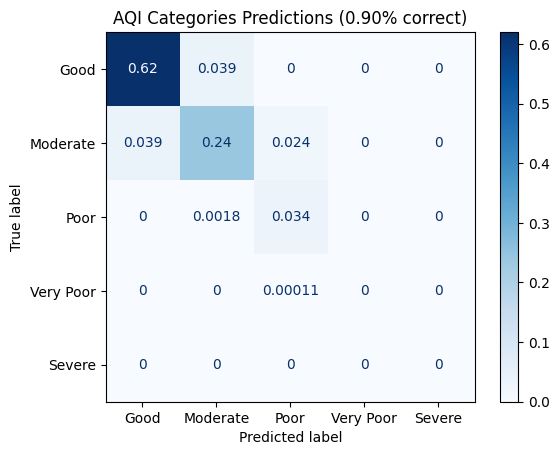

---------------------------------------------
> Absolute Mean AQI Difference: 7.69
> Positive Average AQI Difference: 7.52
> Negative Average AQI Difference: -7.92
> Percentage of Positive Differences: 55.97%
> Percentage of Negative Differences: 43.82%
> Percentage of Agent Values:
   - Same agent: 88.39
   - Different agents: 11.61
Station PORTA SAN FELICE Hourly


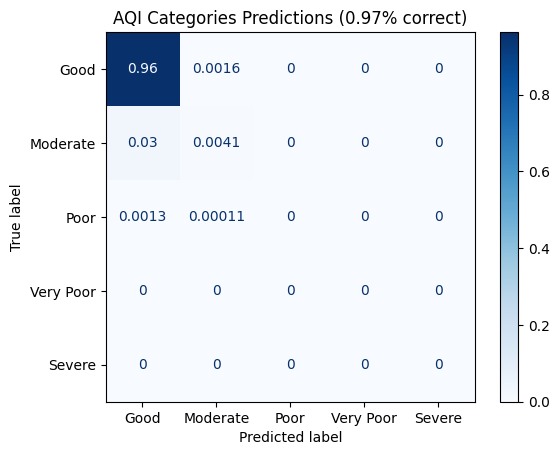

---------------------------------------------
> Absolute Mean AQI Difference: 6.61
> Positive Average AQI Difference: 6.01
> Negative Average AQI Difference: -7.73
> Percentage of Positive Differences: 64.65%
> Percentage of Negative Differences: 35.15%
> Percentage of Agent Values:
   - Same agent: 57.01
   - Different agents: 42.99
Station VIA CHIARINI Hourly


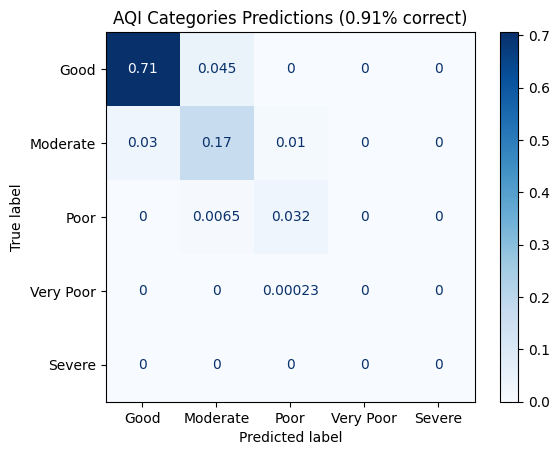

---------------------------------------------
> Absolute Mean AQI Difference: 8.13
> Positive Average AQI Difference: 8.94
> Negative Average AQI Difference: -6.97
> Percentage of Positive Differences: 58.75%
> Percentage of Negative Differences: 40.94%
> Percentage of Agent Values:
   - Same agent: 84.7
   - Different agents: 15.3
Station GIARDINI MARGHERITA Daily


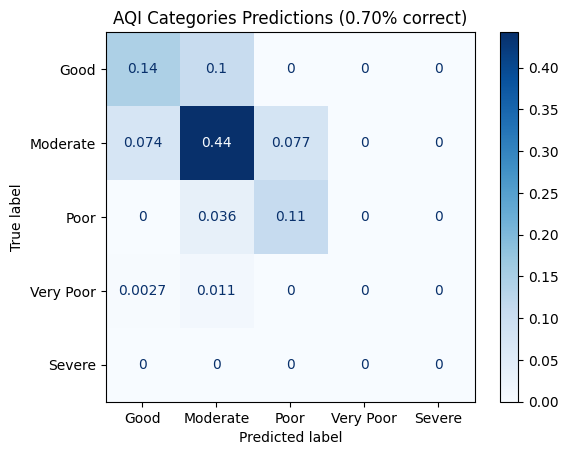

---------------------------------------------
> Absolute Mean AQI Difference: 14.25
> Positive Average AQI Difference: 13.06
> Negative Average AQI Difference: -15.78
> Percentage of Positive Differences: 56.01%
> Percentage of Negative Differences: 43.99%
> Percentage of Agent Values:
   - Same agent: 73.77
   - Different agents: 26.23
Station PORTA SAN FELICE Daily


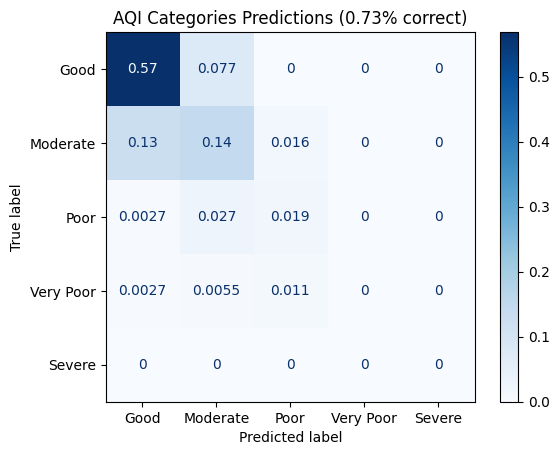

---------------------------------------------
> Absolute Mean AQI Difference: 14.83
> Positive Average AQI Difference: 11.58
> Negative Average AQI Difference: -18.96
> Percentage of Positive Differences: 56.01%
> Percentage of Negative Differences: 43.99%
> Percentage of Agent Values:
   - Same agent: 85.79
   - Different agents: 14.21
Station VIA CHIARINI Daily


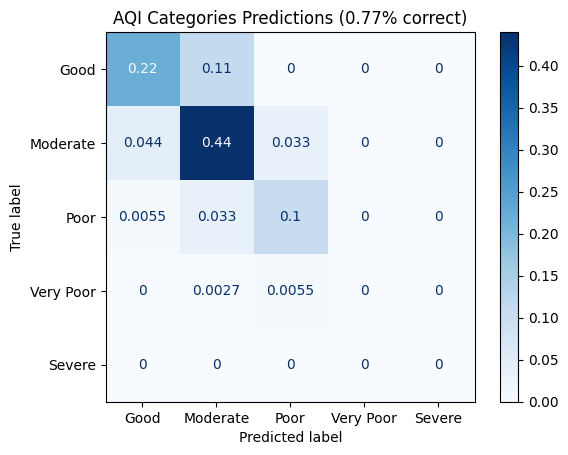

---------------------------------------------
> Absolute Mean AQI Difference: 12.21
> Positive Average AQI Difference: 11.33
> Negative Average AQI Difference: -13.54
> Percentage of Positive Differences: 59.84%
> Percentage of Negative Differences: 40.16%
> Percentage of Agent Values:
   - Same agent: 86.89
   - Different agents: 13.11


In [56]:
compute_AQI_and_show_analysis(agents_predictions_informative, test_sets_informative)